<a href="https://colab.research.google.com/github/cshivak/AllureRepo/blob/master/VAEWithUMAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note:

You need to have the data set in the Train and Test folders on your drive and paths have to be adjusted.

This notebook was executed using the fruits data set available at:
https://www.kaggle.com/moltean/fruits/data

Add a folder named 'results'

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import torch
import os
from skimage import io, transform
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from google.colab.patches import cv2_imshow
import cv2

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
batch_size = 64
epochs = 50
no_cuda = False
seed = 1
log_interval = 50

cuda = not no_cuda and torch.cuda.is_available()

torch.manual_seed(seed)

In [0]:
device = torch.device("cuda" if cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [0]:
train_root = '/content/gdrive/My Drive/Fruits/Training'
val_root = '/content/gdrive/My Drive/Fruits/Test'

In [0]:
train_loader_food = torch.utils.data.DataLoader(
    datasets.ImageFolder(train_root, transform=transforms.ToTensor()),
    batch_size = batch_size, shuffle=True, **kwargs)

val_loader_food = torch.utils.data.DataLoader(
    datasets.ImageFolder(val_root, transform=transforms.ToTensor()),
    batch_size = batch_size, shuffle=True, **kwargs)

In [0]:
class VAE_CNN(nn.Module):
    def __init__(self):
        super(VAE_CNN, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(16)

        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(25 * 25 * 16, 2048)
        self.fc_bn1 = nn.BatchNorm1d(2048)
        self.fc21 = nn.Linear(2048, 2048)
        self.fc22 = nn.Linear(2048, 2048)

        # Sampling vector
        self.fc3 = nn.Linear(2048, 2048)
        self.fc_bn3 = nn.BatchNorm1d(2048)
        self.fc4 = nn.Linear(2048, 25 * 25 * 16)
        self.fc_bn4 = nn.BatchNorm1d(25 * 25 * 16)

        # Decoder
        self.conv5 = nn.ConvTranspose2d(16, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(32)
        self.conv7 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(16)
        self.conv8 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1, bias=False)

        self.relu = nn.ReLU()

    def encode(self, x):
        conv1 = self.relu(self.bn1(self.conv1(x)))
        conv2 = self.relu(self.bn2(self.conv2(conv1)))
        conv3 = self.relu(self.bn3(self.conv3(conv2)))
        conv4 = self.relu(self.bn4(self.conv4(conv3))).view(-1, 25 * 25 * 16)

        fc1 = self.relu(self.fc_bn1(self.fc1(conv4)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        
        return r1, r2

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3))).view(-1, 16, 25, 25)

        conv5 = self.relu(self.bn5(self.conv5(fc4)))
        conv6 = self.relu(self.bn6(self.conv6(conv5)))
        conv7 = self.relu(self.bn7(self.conv7(conv6)))
        return self.conv8(conv7).view(-1, 3, 100, 100)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [0]:
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")

    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD

In [0]:
model = VAE_CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [0]:
loss_mse = customLoss()

In [0]:
val_losses = []
train_losses = []

In [0]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader_food):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader_food.dataset),
                       100. * batch_idx / len(train_loader_food),
                       loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader_food.dataset)))
    train_losses.append(train_loss / len(train_loader_food.dataset))

In [0]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(val_loader_food):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_mse(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                        recon_batch.view(batch_size, 3, 100, 100)[:n]])
                save_image(comparison.cpu(),
                           '/content/results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(val_loader_food.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    val_losses.append(test_loss)
    return mu, logvar

In [16]:
for epoch in range(1, epochs + 1):
    train(epoch)
    mu, logvar = test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 2048).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 3, 100, 100),
                   '/content/results/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/1902 (0%)]	Loss: 6901.150391
====> Epoch: 1 Average loss: 4754.4088
====> Test set loss: 3170.5803
Train Epoch: 2 [0/1902 (0%)]	Loss: 2766.535400
====> Epoch: 2 Average loss: 2124.8095
====> Test set loss: 2440.5829
Train Epoch: 3 [0/1902 (0%)]	Loss: 1855.769409
====> Epoch: 3 Average loss: 1465.0143
====> Test set loss: 1328.6968
Train Epoch: 4 [0/1902 (0%)]	Loss: 1121.526733
====> Epoch: 4 Average loss: 1518.1137
====> Test set loss: 3162.2521
Train Epoch: 5 [0/1902 (0%)]	Loss: 1447.948242
====> Epoch: 5 Average loss: 1210.1502
====> Test set loss: 1209.7553
Train Epoch: 6 [0/1902 (0%)]	Loss: 956.786255
====> Epoch: 6 Average loss: 934.5411
====> Test set loss: 1449.2230
Train Epoch: 7 [0/1902 (0%)]	Loss: 976.942749
====> Epoch: 7 Average loss: 1199.9215
====> Test set loss: 1001.8574
Train Epoch: 8 [0/1902 (0%)]	Loss: 802.951111
====> Epoch: 8 Average loss: 768.8771
====> Test set loss: 1032.7004
Train Epoch: 9 [0/1902 (0%)]	Loss: 783.222351
====> Epoch: 9 Average 

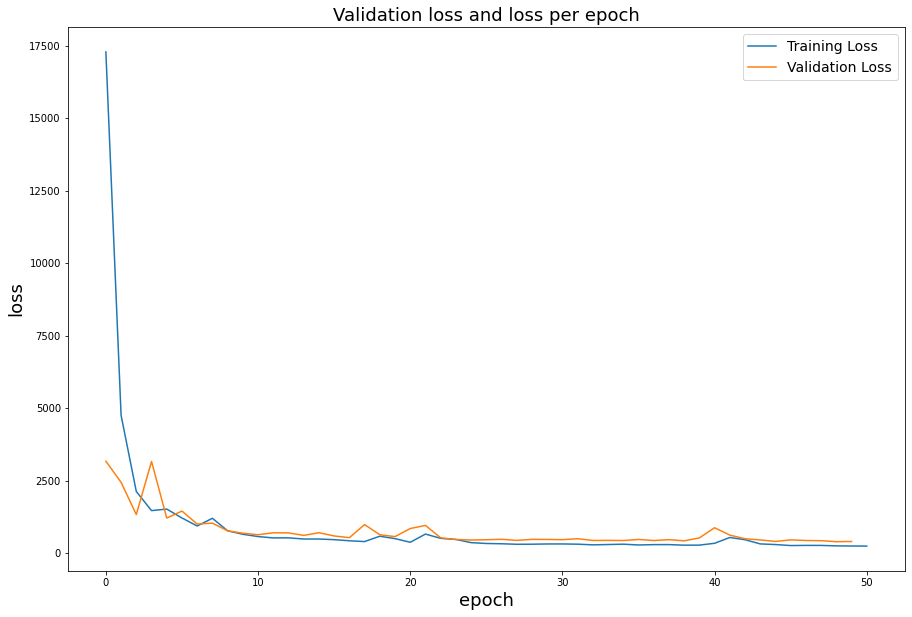

In [17]:
plt.figure(figsize=(15,10))
plt.plot(range(len(train_losses)),train_losses)
plt.plot(range(len(val_losses)),val_losses)
plt.title("Validation loss and loss per epoch",fontsize=18)
plt.xlabel("epoch",fontsize=18)
plt.ylabel("loss",fontsize=18)
plt.legend(['Training Loss','Validation Loss'],fontsize=14)
plt.show()

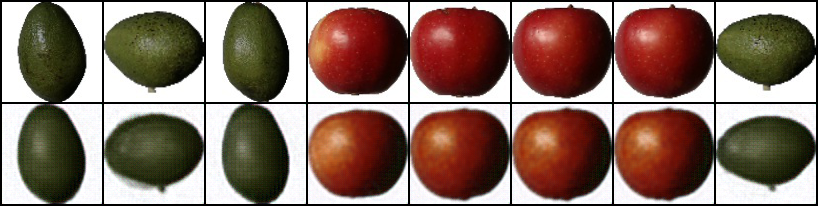

In [18]:
cv2_imshow(cv2.imread('/content/results/reconstruction_50.png'))

In [20]:
# Build target list that contains unique id for each class
test_root = '/content/gdrive/My Drive/Fruits/Test'
path, dirs, files = next(os.walk(test_root))
target = []
classes = len(dirs)
i = 0
for dirName in dirs:
  classPath = os.path.join(test_root, dirName)
  p, d, f = next(os.walk(classPath))
  print('Length of class {0}: {1}'.format(i, len(f)))
  for j in range(len(f)):
    target.append(i)
  i += 1
print('Total target size: {0}'.format(len(target)))

Length of class 0: 164
Length of class 1: 164
Length of class 2: 143
Length of class 3: 166
Total target size: 637


In [0]:
# Obtain encoder output for the test set
test_root = '/content/gdrive/My Drive/Fruits/Test'
test_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(test_root, transform=transforms.ToTensor()),
    batch_size = batch_size, shuffle=True, **kwargs)
meanList = []
varList = []
for i, (data, _) in enumerate(test_loader):
  data = data.to(device)
  recon_batch, mu, logvar = model(data)
  meanList.extend(mu)
  varList.extend(logvar)
meanList = torch.stack(meanList)
varList = torch.stack(varList)

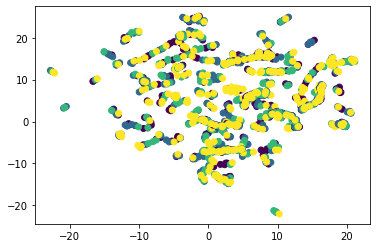

In [22]:
#UMAP for mean of the images in the test set
fit = umap.UMAP(n_neighbors=4,
        min_dist=1,
        n_components=2,
        metric = 'euclidean',)
u = fit.fit_transform(meanList.cpu().detach().numpy())
plt.scatter(u[:,0], u[:,1], c = target)

fit = umap.UMAP(n_neighbors=20, min_dist=0.5, n_components=2, metric = 'euclidean',)
u = fit.fit_transform(meanList.cpu().detach().numpy())
plt.scatter(u[:,0], u[:,1], c = target)


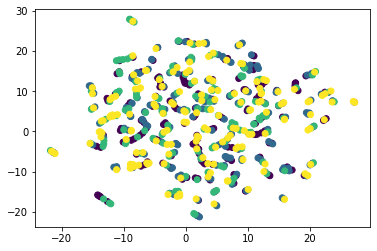

In [23]:
# UMAP for standard deviation of images in the test set
fit = umap.UMAP(n_neighbors=3,
        min_dist=1,
        n_components=2,
        metric = 'euclidean',)
u = fit.fit_transform(varList.cpu().detach().numpy())
plt.scatter(u[:,0], u[:,1], c = target)

In [0]:
def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    data = meanList.cpu().detach().numpy()
    u = fit.fit_transform(data);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c=target)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=target)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=target, s=100)
    plt.title(title, fontsize=18)

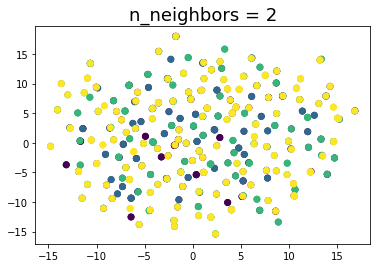

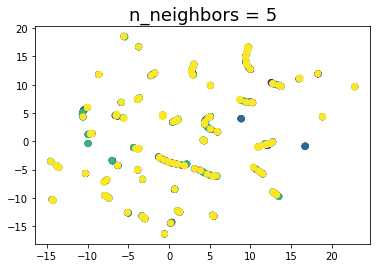

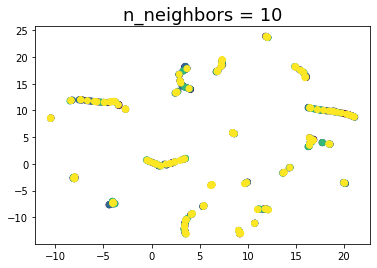

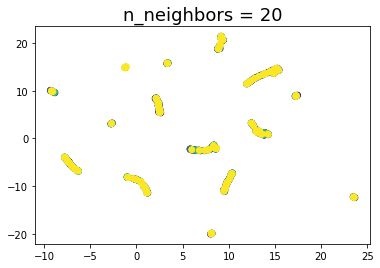

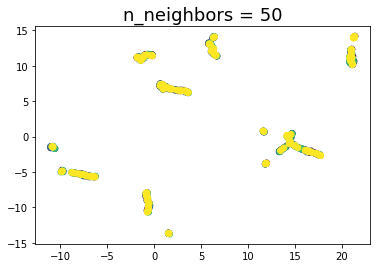

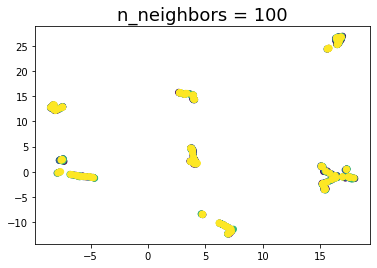

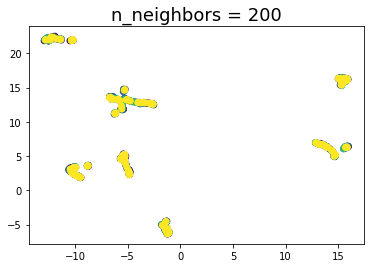

In [25]:
for n in (2, 5, 10, 20, 50, 100, 200):
    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))